In [13]:
###   For each house, calculate the metrics for all the trips within certain range

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
taxi = pd.read_csv("./datasets/nyc-taxi-trip-duration-train.csv", index_col=0)

taxi.pickup_datetime = pd.to_datetime(taxi.pickup_datetime)
taxi.dropoff_datetime = pd.to_datetime(taxi.dropoff_datetime)

In [3]:
def latlong2meter(c_lat, c_long, p_lat, p_long):
    '''
    convert the latlong to meter coordinate, assuming the center is (0, 0)
    '''
    
    R = 6378137                              # radius of Earth
    r = np.cos(c_lat * np.pi / 180) * R      # radius of horizontal section circle at c_lat
    d_lat = (p_lat - c_lat) * np.pi / 180
    d_long = (p_long - c_long) * np.pi / 180
    x = r * d_lat
    y = R * d_long
    
    return x, y

In [4]:
NYC_center = np.median((taxi.pickup_latitude,taxi.dropoff_latitude)), np.median((taxi.pickup_longitude, taxi.dropoff_longitude))

X, Y = latlong2meter(NYC_center[0], NYC_center[1], taxi.pickup_latitude, taxi.pickup_longitude)
taxi.insert(6, column="pickup_x", value=X)
taxi.insert(7, column="pickup_y", value=Y)

X, Y = latlong2meter(NYC_center[0], NYC_center[1], taxi.dropoff_latitude, taxi.dropoff_longitude)
taxi.insert(10, column="dropoff_x", value=X)
taxi.insert(11, column="dropoff_y", value=Y)

diff_x = taxi.dropoff_x - taxi.pickup_x
diff_y = taxi.dropoff_y - taxi.pickup_y
diff = diff_x.to_frame(name="diff_x").join(diff_y.to_frame(name="diff_y"))

taxi.insert(14, column="trip_city_dist", value=np.sum(np.abs(diff), axis=1))

In [5]:
def subsample_month(df, frac=1/6, shuffle=True, random_state=323):
    '''
    subsample each month using pickup time
    '''
    
    time = ["2016-01", "2016-02", "2016-03", "2016-04", "2016-05", "2016-06", "2016-07"]
    np.random.seed(random_state)
    temp = []
    for i in range(6):
        temp.append(taxi.loc[(taxi.pickup_datetime > pd.Timestamp(time[i])) & (taxi.pickup_datetime < pd.Timestamp(time[i+1]))].sample(frac=frac))
    returns = pd.concat(temp)
    if shuffle:
        return returns.sample(frac=1)
    else:
        return returns

In [6]:
taxi_sub = subsample_month(taxi)
taxi_sub.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,pickup_x,pickup_y,dropoff_longitude,dropoff_latitude,dropoff_x,dropoff_y,store_and_fwd_flag,trip_duration,trip_city_dist
id,,,,,,,,,,,,,,,
id3663558,2,2016-01-09 15:01:27,2016-01-09 15:31:33,1,-73.970360,40.761688,621.484209,1167.787932,-73.986809,40.776531,1873.137966,-663.303545,N,1806,3082.745234
id2677210,2,2016-03-05 00:53:00,2016-03-05 01:02:12,1,-73.968933,40.754662,28.951128,1326.607091,-73.987221,40.761021,565.190350,-709.165762,N,552,2572.012075
id1979697,2,2016-01-28 23:49:42,2016-01-28 23:59:24,1,-73.988029,40.763062,737.288720,-799.191596,-73.990723,40.739559,-1244.576814,-1098.994607,N,582,2281.668546
id1923723,1,2016-02-21 13:01:33,2016-02-21 13:10:18,1,-73.946060,40.775631,1797.221675,3872.809433,-73.974838,40.787708,2815.658014,669.248648,N,525,4221.997124
id2381767,1,2016-03-30 10:13:37,2016-03-30 10:22:01,1,-73.957870,40.773609,1626.731701,2558.092547,-73.936684,40.794411,3380.848364,4916.599519,N,504,4112.623636


In [7]:
house = pd.read_csv("./datasets/0_houseGeoClean_id.csv")
house_clean = house.loc[:, ["id", "latitude", "longitude"]]

house_clean.head()

,id,latitude,longitude
0,2,40.530317,-74.219194
1,3,40.532668,-74.222289
2,4,40.532515,-74.221103
3,6,40.535582,-74.221539
4,7,40.535688,-74.222679


In [8]:
def boundary_count(x, y, df, r=500, PUDO="pickup"):
    dist_all = np.abs(df[PUDO+"_x"] - x) + np.abs(df[PUDO+"_y"] - y)
    count = sum(dist_all < r)
    index_list = dist_all[dist_all < r].index
    
    return count, index_list

In [9]:
def insert_taxi(df, taxi_df, r=500, col=3, nrows=None):
    '''
    insert taxi features to df at columns col
    '''
    # empty placeholder
    X, Y = latlong2meter(NYC_center[0], NYC_center[1], df.latitude, df.longitude)
    df.insert(col, column="x", value=X)
    df.insert(col+1, column="y", value=Y)

    df.insert(col+2, column="pickup_count", value=None)
    df.insert(col+3, column="pickup_trip_id", value=None)
    df.insert(col+4, column="pickup_trip_med_dist", value=None)
    df.insert(col+5, column="pickup_trip_med_time", value=None)
    df.insert(col+6, column="pickup_trip_med_speed", value=None)
    df.insert(col+7, column="pickup_trip_avg_passenger", value=None)
    
    df.insert(col+8, column="dropoff_count", value=None)
    df.insert(col+9, column="dropoff_trip_id", value=None)
    df.insert(col+10, column="dropoff_trip_med_dist", value=None)
    df.insert(col+11, column="dropoff_trip_med_time", value=None)
    df.insert(col+12, column="dropoff_trip_med_speed", value=None)
    df.insert(col+13, column="dropoff_trip_avg_passenger", value=None)
    
    l = len(df) if not nrows else nrows
    
    for i in range(l):
        xx = df.loc[i].x
        yy = df.loc[i].y
        count, index_list = boundary_count(xx, yy, taxi_df, r, PUDO="pickup")
        dist = taxi_df.loc[taxi_df.index.isin(index_list), "trip_city_dist"]
        time = taxi_df.loc[taxi_df.index.isin(index_list), "trip_duration"]
        passenger = taxi_df.loc[taxi_df.index.isin(index_list), "passenger_count"]
        df.loc[i, "pickup_count"] = count
        df.loc[i, "pickup_trip_id"] = str(index_list.tolist())
        df.loc[i, "pickup_trip_med_dist"] = dist.median()
        df.loc[i, "pickup_trip_med_time"] = time.median()
        df.loc[i, "pickup_trip_med_speed"] = np.divide(dist, time).median()
        df.loc[i, "pickup_trip_avg_passenger"] = passenger.mean()

        count, index_list = boundary_count(xx, yy, taxi_df, r, PUDO="dropoff")
        dist = taxi_df.loc[taxi_df.index.isin(index_list), "trip_city_dist"]
        time = taxi_df.loc[taxi_df.index.isin(index_list), "trip_duration"]
        passenger = taxi_df.loc[taxi_df.index.isin(index_list), "passenger_count"]
        df.loc[i, "dropoff_count"] = count
        df.loc[i, "dropoff_trip_id"] = str(index_list.tolist())
        df.loc[i, "dropoff_trip_med_dist"] = dist.median()
        df.loc[i, "dropoff_trip_med_time"] = time.median()
        df.loc[i, "dropoff_trip_med_speed"] = np.divide(dist, time).median()
        df.loc[i, "dropoff_trip_avg_passenger"] = passenger.mean()

In [10]:
insert_taxi(house_clean, taxi_sub, col=3)

In [11]:
house_clean.head(15)

,id,latitude,longitude,x,y,pickup_count,pickup_trip_id,pickup_trip_med_dist,pickup_trip_med_time,pickup_trip_med_speed,pickup_trip_avg_passenger,dropoff_count,dropoff_trip_id,dropoff_trip_med_dist,dropoff_trip_med_time,dropoff_trip_med_speed,dropoff_trip_avg_passenger
0,2,40.530317,-74.219194,-18889.206018,-26532.263726,0,[],NaN,NaN,NaN,NaN,0,[],NaN,NaN,NaN,NaN
1,3,40.532668,-74.222289,-18690.938088,-26876.819814,0,[],NaN,NaN,NaN,NaN,0,[],NaN,NaN,NaN,NaN
2,4,40.532515,-74.221103,-18703.865306,-26744.783766,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
3,6,40.535582,-74.221539,-18445.219766,-26793.385856,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
4,7,40.535688,-74.222679,-18436.255883,-26920.212151,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
5,10,40.539070,-74.220799,-18151.089731,-26710.920377,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
6,11,40.539430,-74.220763,-18120.749138,-26706.924007,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
7,12,40.538584,-74.221250,-18192.063866,-26761.147731,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
8,13,40.537932,-74.222082,-18247.061460,-26853.843471,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
9,14,40.538790,-74.222394,-18174.692654,-26888.530624,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1


In [41]:
house_clean = house_clean.rename(columns={"id": "house_id"})
house_clean.head()

,house_id,latitude,longitude,x,y,pickup_count,pickup_trip_id,pickup_trip_med_dist,pickup_trip_med_time,pickup_trip_med_speed,pickup_trip_avg_passenger,dropoff_count,dropoff_trip_id,dropoff_trip_med_dist,dropoff_trip_med_time,dropoff_trip_med_speed,dropoff_trip_avg_passenger
0,2,40.530317,-74.219194,-18889.206018,-26532.263726,0,[],NaN,NaN,NaN,NaN,0,[],NaN,NaN,NaN,NaN
1,3,40.532668,-74.222289,-18690.938088,-26876.819814,0,[],NaN,NaN,NaN,NaN,0,[],NaN,NaN,NaN,NaN
2,4,40.532515,-74.221103,-18703.865306,-26744.783766,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
3,6,40.535582,-74.221539,-18445.219766,-26793.385856,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1
4,7,40.535688,-74.222679,-18436.255883,-26920.212151,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.1,3738,15.7421,1


In [42]:
house_clean.to_csv("./datasets/house_clean_taxi.csv")

In [10]:
temp = pd.read_csv("./datasets/house_subway_bike_taxi_uber.csv")
temp = temp.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
temp = temp.rename(columns={"Unnamed: 0_x": "house_id"})

/Users/wang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
temp.head()

,house_id,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,taxi_out_distance_sum,taxi_out_distance_median,taxi_in_passenger_sum,taxi_in_passenger_median,taxi_in_v_median,taxi_in_time_sec_sum,taxi_in_time_sec_median,taxi_in_distance_sum,taxi_in_distance_median,uber_trips
0,2,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,NaN,NaN,3.0,1.0,19.332349,5970.0,2985.0,164612.4647,52066.00333,NaN
1,3,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,NaN,NaN,3.0,1.0,19.332349,5970.0,2985.0,164612.4647,52066.00333,NaN
2,4,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,NaN,NaN,3.0,1.0,19.332349,5970.0,2985.0,164612.4647,52066.00333,NaN
3,6,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7317,126,,B2,112 ROBIN COURT,...,NaN,NaN,3.0,1.0,19.332349,5970.0,2985.0,164612.4647,52066.00333,NaN
4,7,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7316,93,,B2,125 DARNELL LANE,...,NaN,NaN,3.0,1.0,19.332349,5970.0,2985.0,164612.4647,52066.00333,NaN


In [145]:
ttt = pd.merge(temp, house_clean, on="house_id")

In [146]:
#ttt.to_csv("./datasets/house_subway_bike_taxi_uber_all.csv")

In [147]:
ttt.insert(loc=74, column="pickup_missing_originally", value=(ttt.pickup_count == 0))
ttt.insert(loc=81, column="dropoff_missing_originally", value=(ttt.dropoff_count == 0))

In [164]:
pickup_noNA = ttt[ttt.pickup_count != 0].index
k = 5

for i in range(len(ttt)):
    if i % 500 == 0 and i != 0:
        print("=", end="")
        if i % 5000 == 0:
            print(">", end=" ")
            if i // 5000 == 5:
                print("")
    if ttt.loc[i, "pickup_count"] == 0:
        xx = ttt.loc[i, "x"]
        yy = ttt.loc[i, "y"]
        
        dist = np.abs(ttt.loc[ttt.index.isin(pickup_noNA), "x"] - xx) + np.abs(ttt.loc[ttt.index.isin(pickup_noNA), "y"] - yy)
        knn_id = dist.sort_values(ascending=True).head(k).index
        ttt.loc[ttt.index.isin(knn_id)].mean()
        ttt.iloc[i, [75,77,78,79,80]] = ttt.iloc[ttt.index.isin(knn_id), [75,77,78,79,80]].mean()

==========> ==========> ==========> ==========> ==========> 
==========> ==========> ==========> ==========> ==========> =========

In [165]:
pickup_noNA = ttt[ttt.dropoff_count != 0].index
k = 5

for i in range(len(ttt)):
    if ttt.loc[i, "dropoff_count"] == 0:
        xx = ttt.loc[i, "x"]
        yy = ttt.loc[i, "y"]
        
        dist = np.abs(ttt.loc[ttt.index.isin(pickup_noNA), "x"] - xx) + np.abs(ttt.loc[ttt.index.isin(pickup_noNA), "y"] - yy)
        knn_id = dist.sort_values(ascending=True).head(k).index
        ttt.loc[ttt.index.isin(knn_id)].mean()
        ttt.iloc[i, [82,84,85,86,87]] = ttt.iloc[ttt.index.isin(knn_id), [82,84,85,86,87]].mean()

In [168]:
ttt.iloc[:, 74:].head(20)

,pickup_missing_originally,pickup_count,pickup_trip_id,pickup_trip_med_dist,pickup_trip_med_time,pickup_trip_med_speed,pickup_trip_avg_passenger,dropoff_missing_originally,dropoff_count,dropoff_trip_id,dropoff_trip_med_dist,dropoff_trip_med_time,dropoff_trip_med_speed,dropoff_trip_avg_passenger
0,True,1.2,[],0,1458,0,4.2,True,1.0,[],58844.1,3738,15.7421,1
1,True,1.2,[],0,1458,0,4.2,True,1.0,[],58844.1,3738,15.7421,1
2,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
3,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
4,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
5,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
6,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
7,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
8,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1
9,True,1.2,[],0,1458,0,4.2,False,1.0,['id1628841'],58844.1,3738,15.7421,1


In [169]:
ttt.to_csv("./datasets/all_imputation.csv")

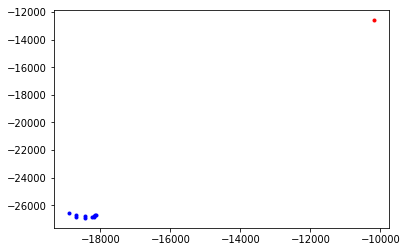

In [163]:
plt.plot(ttt.loc[[0,1,2,3,4,5,6,7,8,9], "x"], ttt.loc[[0,1,2,3,4,5,6,7,8,9], "y"], "b.")
plt.plot(ttt.loc[620, "x"], ttt.loc[620, "y"], "r.")
plt.show()

In [ ]:
plt.plot(ttt.loc[620, "x"], ttt.loc[620, "y"], "r.")
plt.plot()

In [104]:
ttt.dropoff_trip_med_dist.mean()

10655.238742214256

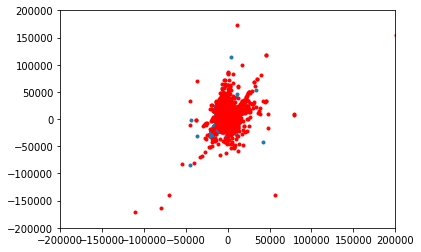

In [170]:
plt.plot(ttt.x, ttt.y, ".")
plt.plot(taxi.pickup_x, taxi.pickup_y, "r.")
plt.xlim((-200000, 200000))
plt.ylim((-200000, 200000))
plt.show()

In [63]:
ttt.dropoff_count.mean()

750.7430338291528

In [64]:
ttt.pickup_count.mean()

795.1538869678175

In [65]:
temp.columns

Index(['house_id', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'latitude', 'longitude', 'SubwayDist',
       'ClosestSubway', 'numSub5min', 'numSub10min', 'id',
       'SubwayDistHaversine', 'ClosestSubwayHaversine', 'bike_minDist',
       'bike_minStationID', 'bike_station.id', 'bike_nRides_start',
       'bike_durationMed_start', 'bike_startTimeAvg', 'bike_startTimeSd',
       'bike_endLatAvg', 'bike_endLatSd', 'bike_endLongAvg', 'bike_endLongSd',
       'bike_females_start', 'bike_ageMed_start', 'bike_nRides_end',
       'bike_durationMed_end', 'bike_endTimeAvg', 'bike_endTimeSd',
       'bike_startLatAvg', 'bik

In [57]:
house_clean.shape

(54657, 17)

In [58]:
temp.shape

(54657, 70)

In [59]:
ttt.shape

(54657, 86)

In [20]:
hc = pd.read_csv("./datasets/house_clean_taxi.csv", index_col=0)

In [21]:
hc.head()

,id,latitude,longitude,x,y,pickup_count,pickup_trip_id,pickup_trip_med_dist,pickup_trip_med_time,pickup_trip_med_speed,pickup_trip_avg_passenger,dropoff_count,dropoff_trip_id,dropoff_trip_med_dist,dropoff_trip_med_time,dropoff_trip_med_speed,dropoff_trip_avg_passenger
0,2,40.530317,-74.219194,-18889.206018,-26532.263726,0,[],NaN,NaN,NaN,NaN,0,[],NaN,NaN,NaN,NaN
1,3,40.532668,-74.222289,-18690.938088,-26876.819814,0,[],NaN,NaN,NaN,NaN,0,[],NaN,NaN,NaN,NaN
2,4,40.532515,-74.221103,-18703.865306,-26744.783766,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.130769,3738.0,15.742143,1.0
3,6,40.535582,-74.221539,-18445.219766,-26793.385856,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.130769,3738.0,15.742143,1.0
4,7,40.535688,-74.222679,-18436.255883,-26920.212151,0,[],NaN,NaN,NaN,NaN,1,['id1628841'],58844.130769,3738.0,15.742143,1.0


In [48]:
NYC_center

(40.75431823730469, -73.98085021972656)

In [261]:
airbnb_4 = pd.read_csv("./datasets/airbnb_listings_2016-04.csv")

X, Y = latlong2meter(NYC_center[0], NYC_center[1], airbnb_4.latitude, airbnb_4.longitude)
airbnb_4.insert(47, column="x", value=X)
airbnb_4.insert(48, column="y", value=Y)

/Users/wang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (40,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [262]:
airbnb_4_clean = airbnb_4.loc[:,["id", "x", "y"]]

airbnb_4_clean.insert(3, column="pickup_count", value=0)
airbnb_4_clean.insert(4, column="pickup_trip_id", value=None)
airbnb_4_clean.insert(5, column="pickup_trip_med_dist", value=0)
airbnb_4_clean.insert(6, column="pickup_trip_med_time", value=0)
airbnb_4_clean.insert(7, column="pickup_trip_med_speed", value=0)

airbnb_4_clean.insert(8, column="dropoff_count", value=0)
airbnb_4_clean.insert(9, column="dropoff_trip_id", value=None)
airbnb_4_clean.insert(10, column="dropoff_trip_med_dist", value=0)
airbnb_4_clean.insert(11, column="dropoff_trip_med_time", value=0)
airbnb_4_clean.insert(12, column="dropoff_trip_med_speed", value=0)

In [263]:
def boundary_count(x, y, df, r=500, PUDO="pickup"):
    dist_all = np.abs(df[PUDO+"_x"] - x) + np.abs(df[PUDO+"_y"] - y)
    count = sum(dist_all < r)
    index_list = dist_all[dist_all < r].index
    
    return count, index_list

In [272]:
for i in range(len(airbnb_4_clean)):
    xx = airbnb_4_clean.loc[i].x
    yy = airbnb_4_clean.loc[i].y
    count, index_list = boundary_count(xx, yy, taxi_4, PUDO="pickup")
    dist = taxi_4.loc[taxi_4.index.isin(index_list), "trip_city_dist"]
    time = taxi_4.loc[taxi_4.index.isin(index_list), "trip_duration"]
    airbnb_4_clean.loc[i, "pickup_count"] = count
    airbnb_4_clean.loc[i, "pickup_trip_id"] = str(index_list.tolist())
    airbnb_4_clean.loc[i, "pickup_trip_med_dist"] = dist.median()
    airbnb_4_clean.loc[i, "pickup_trip_med_time"] = time.median()
    airbnb_4_clean.loc[i, "pickup_trip_med_speed"] = np.divide(dist, time).median()

    count, index_list = boundary_count(xx, yy, taxi_4, PUDO="dropoff")
    dist = taxi_4.loc[taxi_4.index.isin(index_list), "trip_city_dist"]
    time = taxi_4.loc[taxi_4.index.isin(index_list), "trip_duration"]
    airbnb_4_clean.loc[i, "dropoff_count"] = count
    airbnb_4_clean.loc[i, "dropoff_trip_id"] = str(index_list.tolist())
    airbnb_4_clean.loc[i, "dropoff_trip_med_dist"] = dist.median()
    airbnb_4_clean.loc[i, "dropoff_trip_med_time"] = time.median()
    airbnb_4_clean.loc[i, "dropoff_trip_med_speed"] = np.divide(dist, time).median()

In [274]:
airbnb_4_clean.head(20)

,id,x,y,pickup_count,pickup_trip_id,pickup_trip_med_dist,pickup_trip_med_time,pickup_trip_med_speed,dropoff_count,dropoff_trip_id,dropoff_trip_med_dist,dropoff_trip_med_time,dropoff_trip_med_speed
0,1841252,1455.100039,8223.247657,35,"['id1446014', 'id0372992', 'id0845967', 'id115...",3949.572062,617.0,6.199370,107,"['id1045409', 'id2836396', 'id3335369', 'id385...",9012.961187,1364.0,6.271413
1,1886820,7321.706355,22018.765182,0,[],NaN,NaN,NaN,2,"['id3196217', 'id3664378']",15010.173575,1417.0,10.595313
2,7949480,8241.673813,21392.331682,0,[],NaN,NaN,NaN,0,[],NaN,NaN,NaN
3,958444,8266.671151,21386.935431,0,[],NaN,NaN,NaN,0,[],NaN,NaN,NaN
4,9019702,7892.825290,21497.974605,0,[],NaN,NaN,NaN,1,['id2845293'],30502.394114,2090.0,14.594447
5,11675715,8100.233075,21837.472394,0,[],NaN,NaN,NaN,0,[],NaN,NaN,NaN
6,8053533,7916.898501,21324.091448,0,[],NaN,NaN,NaN,1,['id2845293'],30502.394114,2090.0,14.594447
7,5557381,8070.494458,21320.201066,0,[],NaN,NaN,NaN,1,['id2845293'],30502.394114,2090.0,14.594447
8,6627449,8049.476560,21622.790542,0,[],NaN,NaN,NaN,1,['id2845293'],30502.394114,2090.0,14.594447
9,9147025,7635.856426,21296.500159,0,[],NaN,NaN,NaN,2,"['id2845293', 'id3237173']",24011.769617,2270.5,10.871508


In [240]:
xx = airbnb_4_clean.x[0]
yy = airbnb_4_clean.y[0]

count, index_list = boundary_count(xx, yy, taxi_4, PUDO="pickup")

In [221]:
taxi_4.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,pickup_x,pickup_y,dropoff_longitude,dropoff_latitude,dropoff_x,dropoff_y,store_and_fwd_flag,trip_duration,trip_city_dist
id,,,,,,,,,,,,,,,
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-2896.399493,-3249.423002,-74.012268,40.706718,-4013.913024,-3497.418694,N,429,1365.509223
id3379579,2,2016-04-11 17:29:50,2016-04-11 18:08:26,1,-73.991165,40.755562,104.867418,-1148.254025,-73.999290,40.725353,-2442.510145,-2052.758860,N,2316,3451.882398
id1154431,1,2016-04-14 08:48:26,2016-04-14 09:00:37,1,-73.994255,40.745804,-717.987968,-1492.220652,-73.999657,40.723343,-2612.035082,-2093.525275,N,731,2495.351736
id0809232,2,2016-04-01 12:12:25,2016-04-01 12:23:17,1,-73.979538,40.753361,-80.741479,146.079654,-73.963997,40.763458,770.743357,1876.104394,N,652,2581.509575
id2352683,1,2016-04-09 03:34:27,2016-04-09 03:41:30,1,-73.995865,40.758812,378.938094,-1671.423019,-73.993324,40.740322,-1180.240975,-1388.606014,N,423,1841.996074


In [242]:
taxi_4.loc[taxi_4.index.isin(index_list)].trip_city_dist.mean()

5089.331336913383

In [72]:
map_r = np.max((taxi.pickup_longitude.max(), taxi.dropoff_longitude.max()))
map_l = np.min((taxi.pickup_longitude.min(), taxi.dropoff_longitude.min()))
map_u = np.max((taxi.pickup_latitude.max(), taxi.dropoff_latitude.max()))
map_d = np.min((taxi.pickup_latitude.min(), taxi.dropoff_latitude.min()))

In [32]:
NYC_center

(-73.98085021972656, 40.75431823730469)